In [52]:
import requests
import matplotlib.pyplot as plt
import os
import re

In [53]:
api_addr = "http://141.56.137.185:5000"

In [54]:
def api_sql_execute(sql):
    try:
        response = requests.get(api_addr+"/hub/"+sql, headers={'Content-Type': 'application/json'})
        result = response.json()
        
        if not response.ok:
            raise Exception(f"HTTP error! status: {result.get('error', response.status_code)}")
        
        return result, False

    except Exception as e:
        return e, True

In [55]:
def api_sql_schema():
    try:
        response = requests.get(api_addr+"/schema", headers={'Content-Type': 'application/json'})
        result = response.json()
        
        if not response.ok:
            raise Exception(f"HTTP error! status: {result.get('error', response.status_code)}")
        
        return result, False

    except Exception as e:
        return e, True

### DB Schema

In [56]:
res, error = api_sql_schema()
if not error:
    print(res.replace('\\r\\n', '\n'))
else:
    print(res)

PRAGMA foreign_keys = ON;

CREATE TABLE IF NOT EXISTS t_category (
    c_id INTEGER PRIMARY KEY AUTOINCREMENT,
    c_category TEXT NOT NULL UNIQUE
);

CREATE TABLE IF NOT EXISTS t_model (
    c_id INTEGER PRIMARY KEY AUTOINCREMENT,
    c_model TEXT NOT NULL UNIQUE
);

CREATE TABLE IF NOT EXISTS t_input (
    c_id INTEGER PRIMARY KEY AUTOINCREMENT,
    c_input TEXT NOT NULL UNIQUE,
    c_rule TEXT,
    c_temperature DECIMAL NOT NULL,
    c_note TEXT,
    t_category_id INTEGER NOT NULL,
    FOREIGN KEY (t_category_id) REFERENCES t_category(c_id)
);

CREATE TABLE IF NOT EXISTS t_output (
    c_id INTEGER PRIMARY KEY AUTOINCREMENT,
    c_output_think TEXT,
    c_output_final TEXT,
    c_total_duration INTEGER NOT NULL,
    c_load_duration INTEGER NOT NULL,
    c_prompt_eval_count INTEGER NOT NULL,
    c_prompt_eval_duration INTEGER NOT NULL,
    c_eval_count INTEGER NOT NULL,
    c_eval_duration INTEGER NOT NULL,
    c_score DECIMAL NOT NULL,
    c_note TEXT,
    t_input_id INTEGER NOT NUL

### Analyse

In [57]:
def get_scores(rules):
    labels_array = []
    results_array = []
    where_clauses = [f"{k} = '{v}'" for rule in rules for k, v in rule.items()]
    where_filter = " AND " + " AND ".join(where_clauses) if where_clauses else ""
    for score in range(1, 6):
        sql = f"""
            SELECT COUNT(*) FROM t_output
            JOIN t_input ON t_input.c_id = t_output.t_input_id 
            JOIN t_model ON t_model.c_id = t_output.t_model_id
            JOIN t_category ON t_category.c_id = t_input.t_category_id
            WHERE c_score = {score}{where_filter};
        """
        res, error = api_sql_execute(sql)
        labels_array.append(score)
        results_array.append(res)
    return labels_array, [row[0]['COUNT(*)'] for row in results_array]

In [58]:
def get_score_average(rules):
    where_clauses = [f"{k} = '{v}'" for rule in rules for k, v in rule.items()]
    where_filter = " WHERE " + " AND ".join(where_clauses) if where_clauses else ""
    sql = f"""
        SELECT AVG(c_score) FROM t_output
        JOIN t_input ON t_input.c_id = t_output.t_input_id 
        JOIN t_model ON t_model.c_id = t_output.t_model_id
        JOIN t_category ON t_category.c_id = t_input.t_category_id
        {where_filter};
    """
    res, error = api_sql_execute(sql)
    return res[0]['AVG(c_score)'] if res and res[0]['AVG(c_score)'] is not None else 0.0

In [59]:
def format_filename(name):
    name = name.lower()
    name = re.sub(r'\s+', '_', name)
    name = re.sub(r'[^\w\-]', '', name)
    return name

In [60]:
""" def show_plot(x, y, x_label, y_label, labels, data, title, save_path):
    plt.figure(figsize=(x, y))
    plt.bar(labels, data, color='skyblue')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show() """

def show_plot(x, y, x_label, y_label, labels, data, title, save_path):
    plt.figure(figsize=(x, y))
    bars = plt.bar(labels, data, color='skyblue')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=9)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


In [61]:
def show_plot_score(labels, data_scores, data_average, title, dir, file_name):
    ed_dir = f'assets/scores/{dir}' if dir else 'assets/scores'
    os.makedirs(ed_dir, exist_ok=True)
    total = sum(data_scores)
    ed_title = f'Distribution of scores' + title + f"\nAverage: {data_average:.2f}\nTotal Data: {total}"
    save_path = f'{ed_dir}/sc_{file_name}.png'
    show_plot(8, 5, 'Score', 'Sum', labels, data_scores, ed_title, save_path)

In [62]:
def show_plot_average(x, y, data, title, x_label, dir, file_name):
    ed_dir = f'assets/averages/{dir}' if dir else 'assets/averages'
    os.makedirs(ed_dir, exist_ok=True)
    labels = [item['label'] for item in data]
    data = [item['data'] for item in data]
    save_path = f'{ed_dir}/av_{file_name}.png'
    show_plot(x, y, x_label, 'Score', labels, data, title, save_path)

In [63]:
res_models, error = api_sql_execute('SELECT * FROM t_model')
res_categories, error = api_sql_execute('SELECT * FROM t_category')

#ids_model = [item['c_id'] for item in res]
#models = [item['c_model'] for item in res]

### Score of each Model

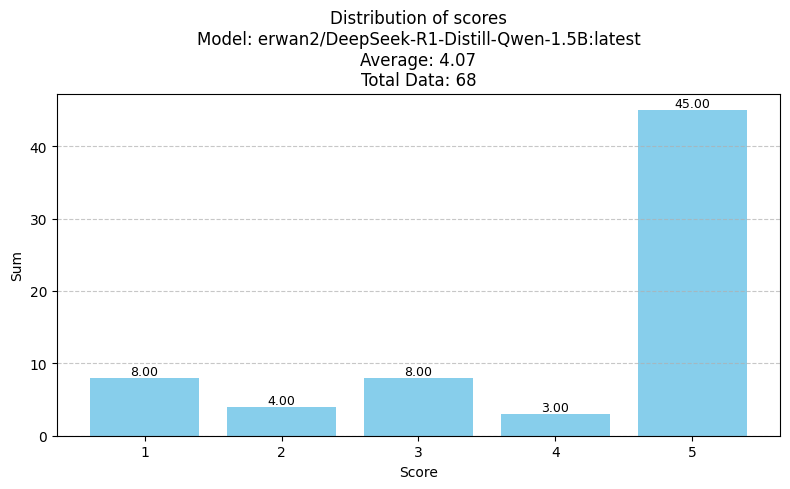

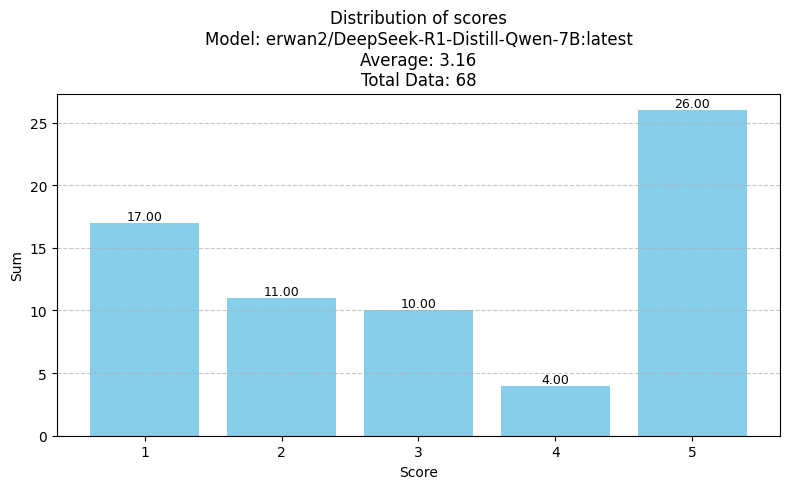

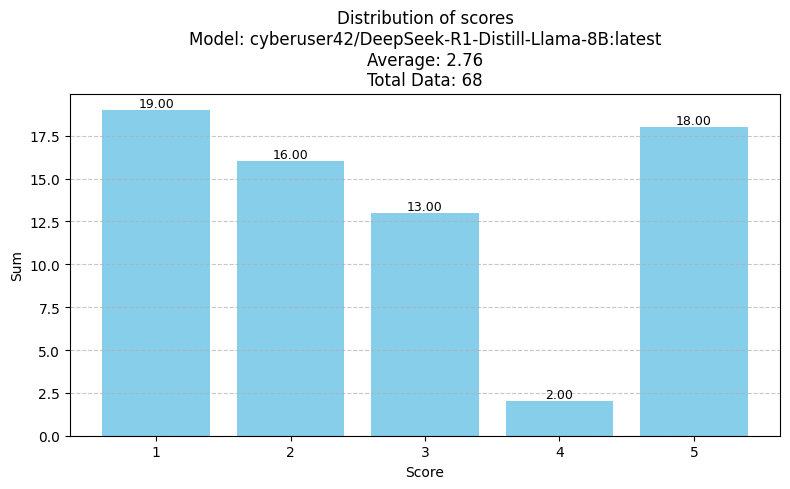

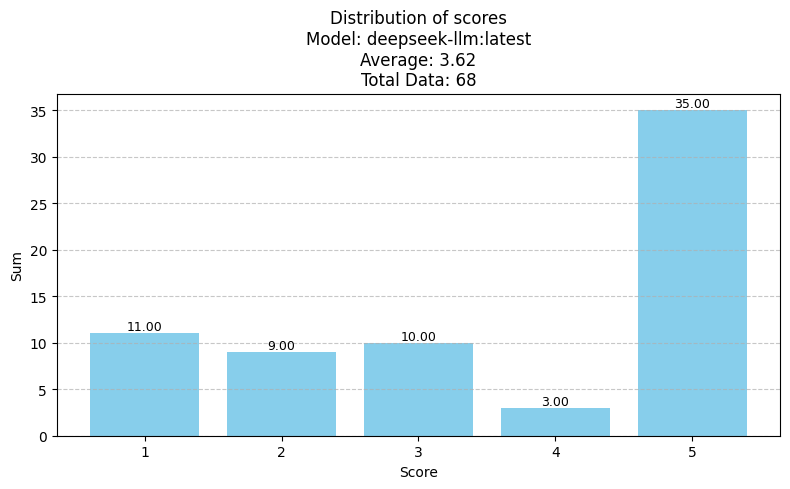

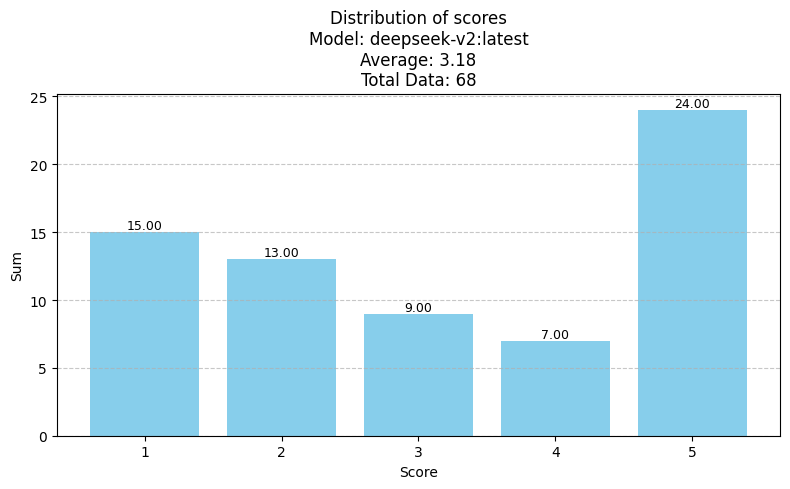

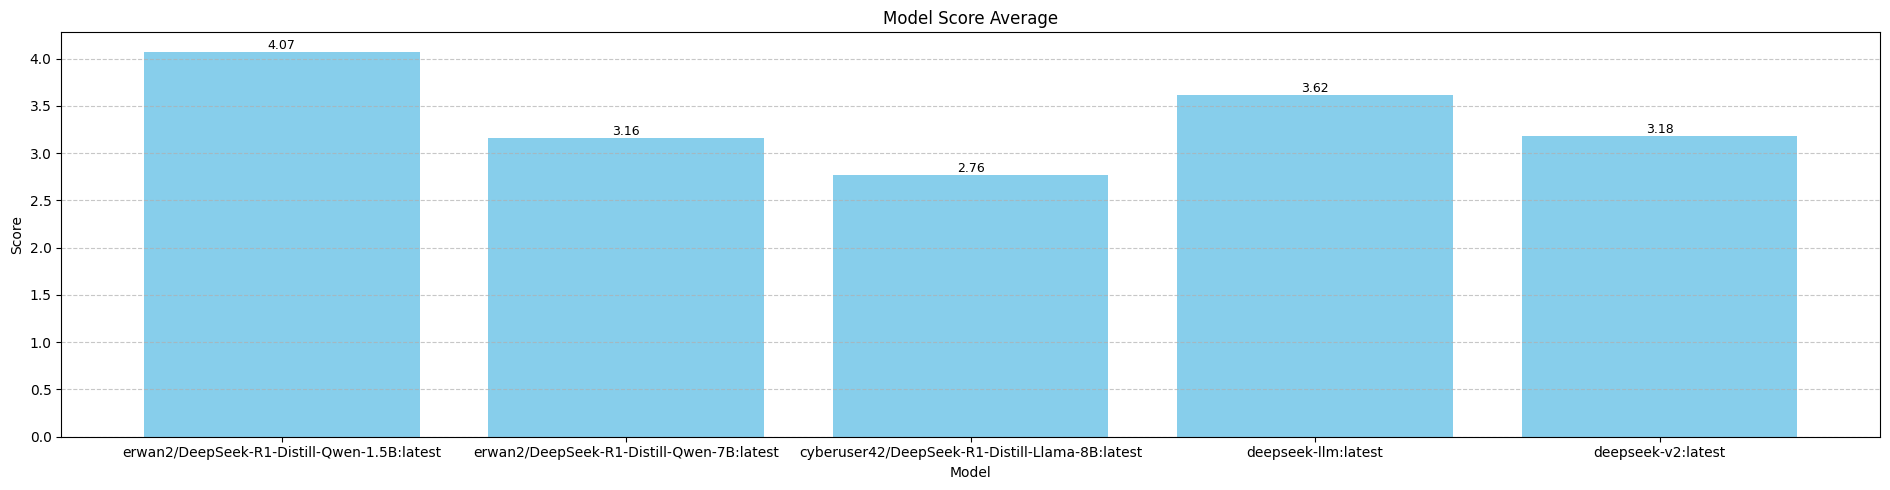

In [64]:
result_average = []
for res_model in res_models:
    id_model = res_model['c_id']
    model = res_model['c_model']
    labels, data_scores = get_scores([{'t_model.c_id':id_model}])
    data_average = get_score_average([{'t_model.c_id':id_model}])
    show_plot_score(labels, data_scores, data_average, f'\nModel: {model}', 'model', format_filename(model))
    result_average.append({'label': model, 'data': data_average})
show_plot_average(19, 5, result_average, 'Model Score Average', 'Model', None, 'model_average')

### Score of each Category

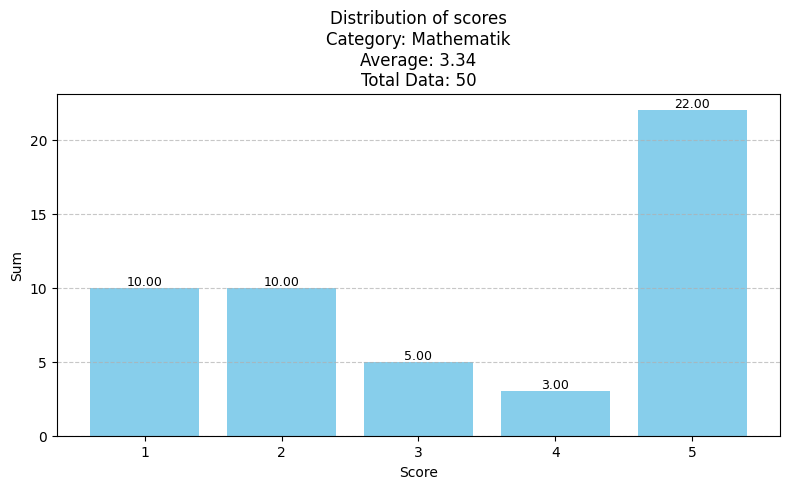

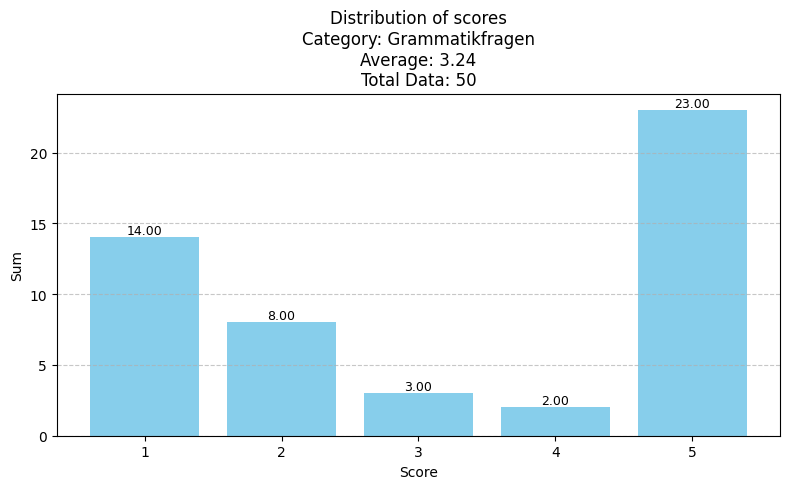

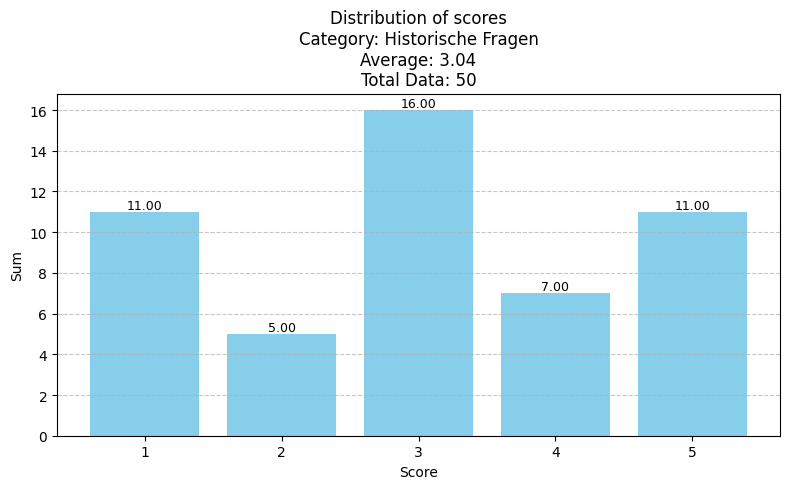

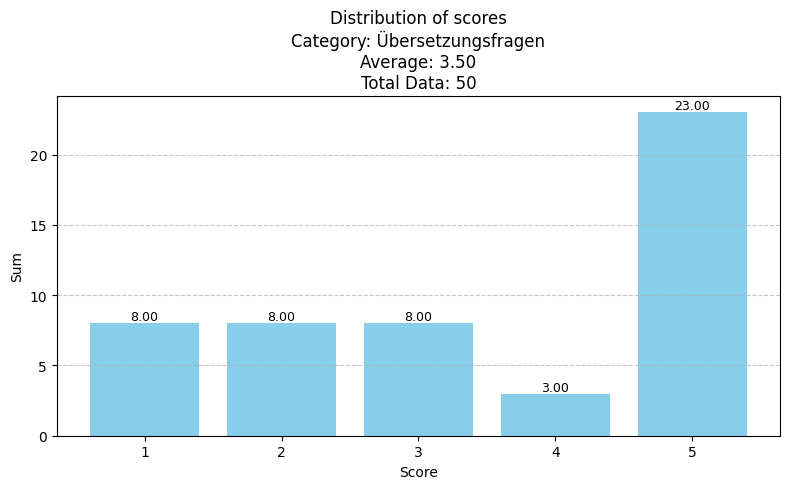

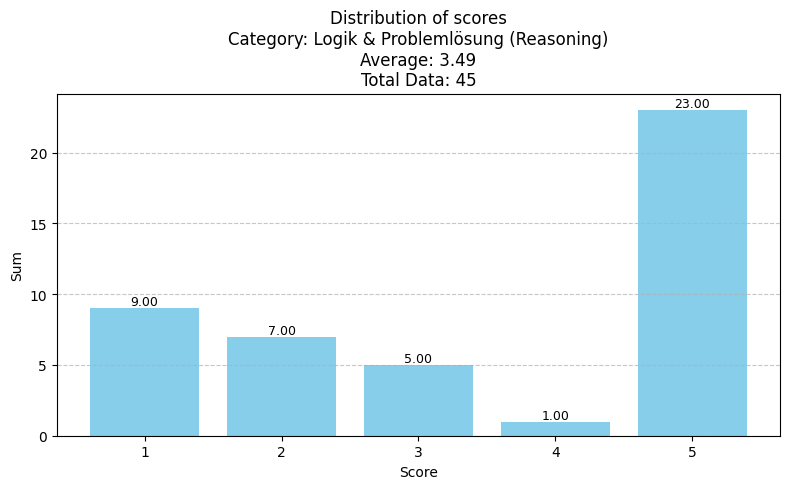

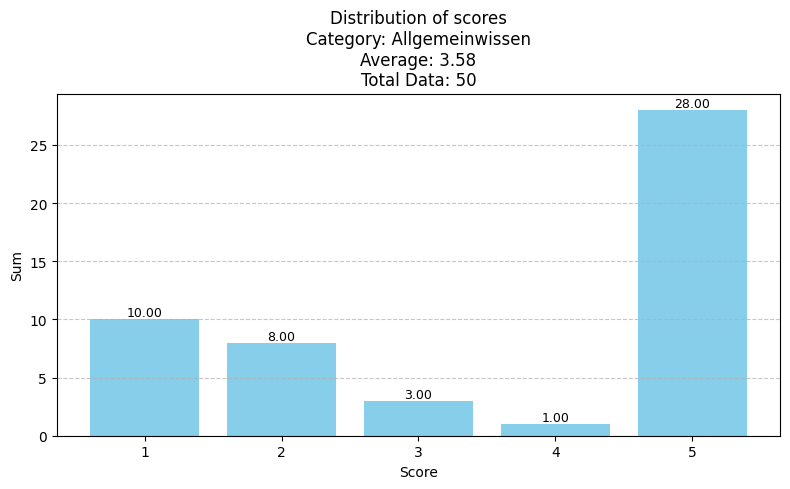

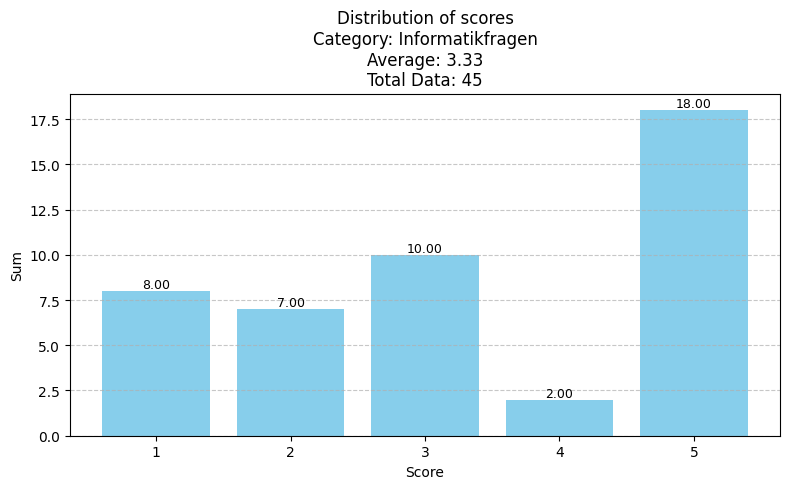

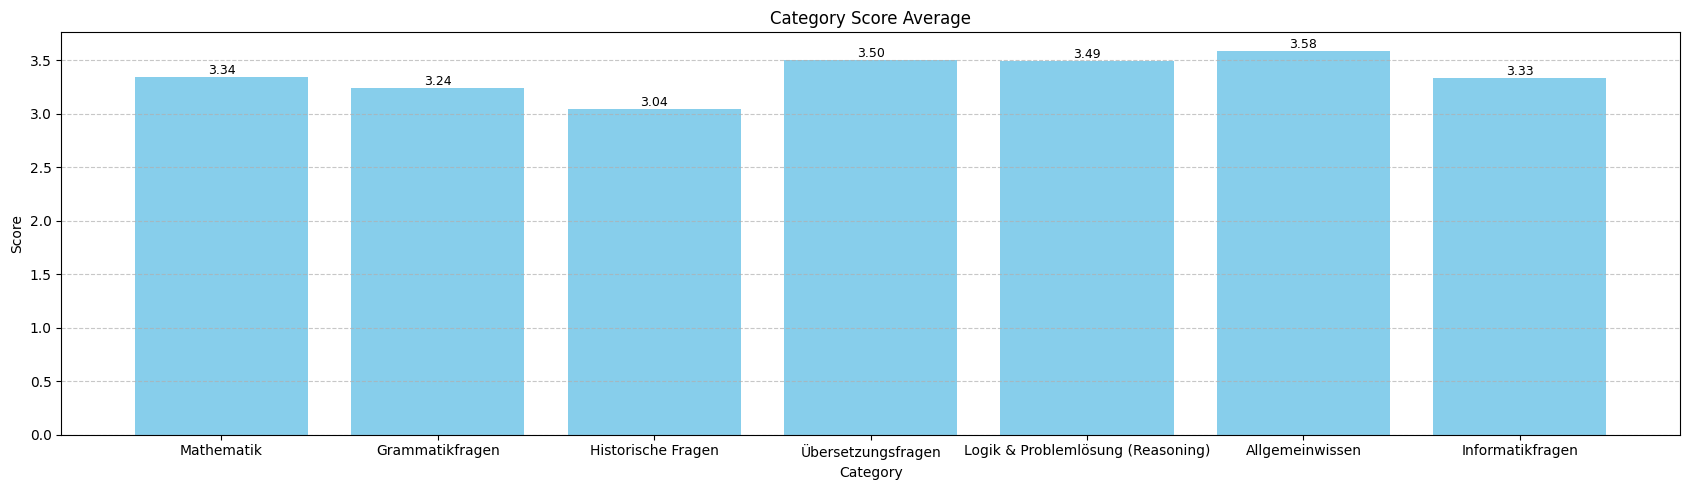

In [65]:
result_average = []
for res_category in res_categories:
    id_category = res_category['c_id']
    category = res_category['c_category']
    labels, data_scores = get_scores([{'t_category.c_id':id_category}])
    data_average = get_score_average([{'t_category.c_id':id_category}])
    show_plot_score(labels, data_scores, data_average, f'\nCategory: {category}', 'category', format_filename(category))
    result_average.append({'label': category, 'data': data_average})
show_plot_average(17, 5, result_average, 'Category Score Average', 'Category', None, 'category_average')

### Score of each Model and Category

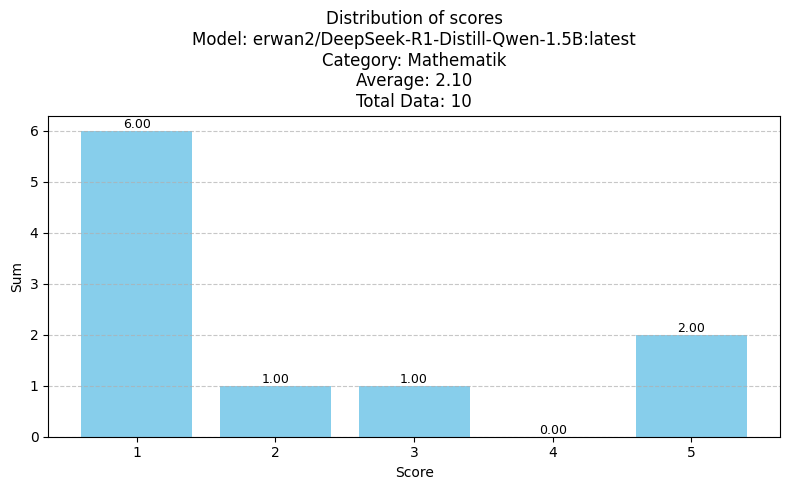

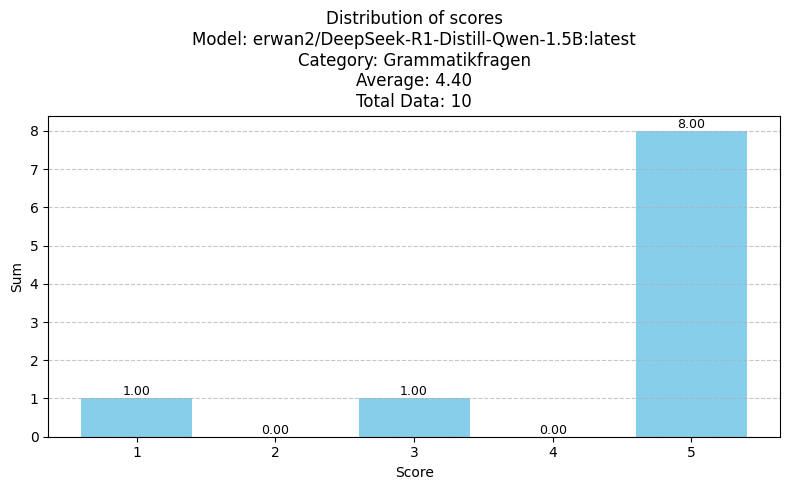

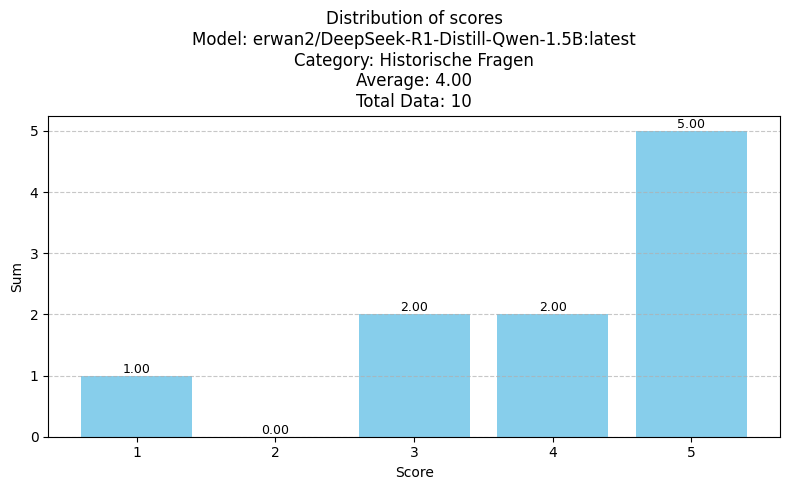

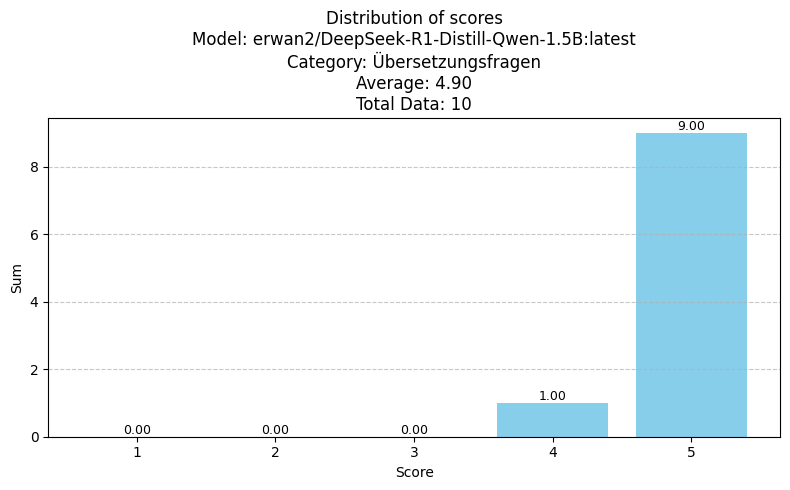

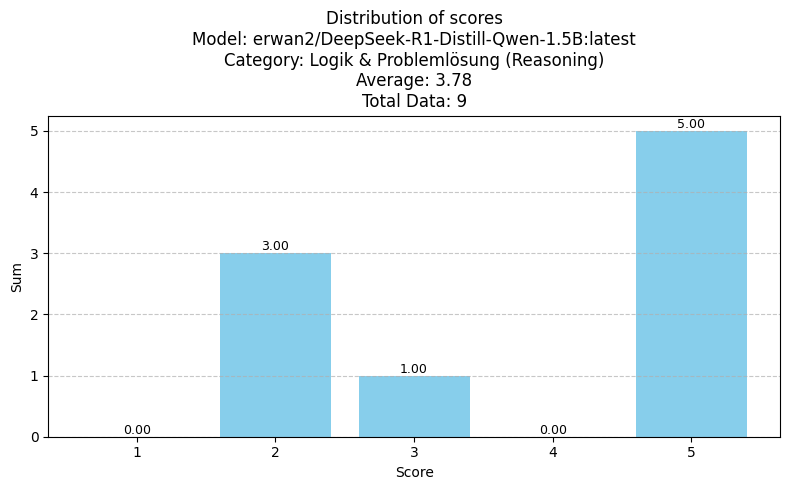

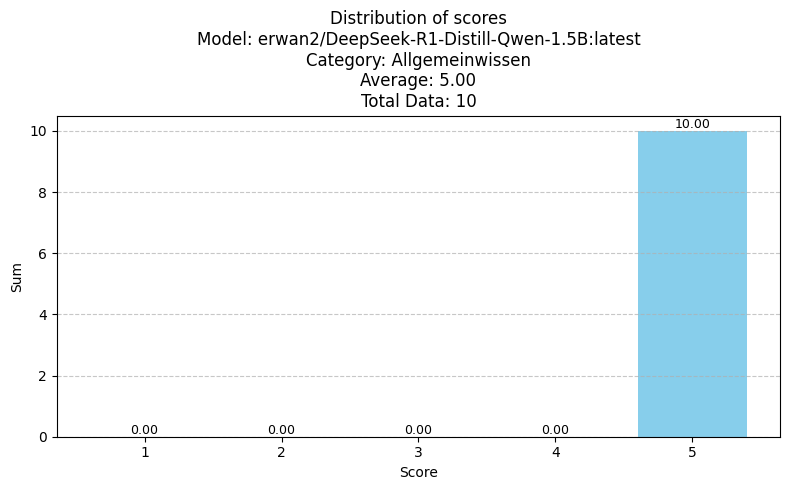

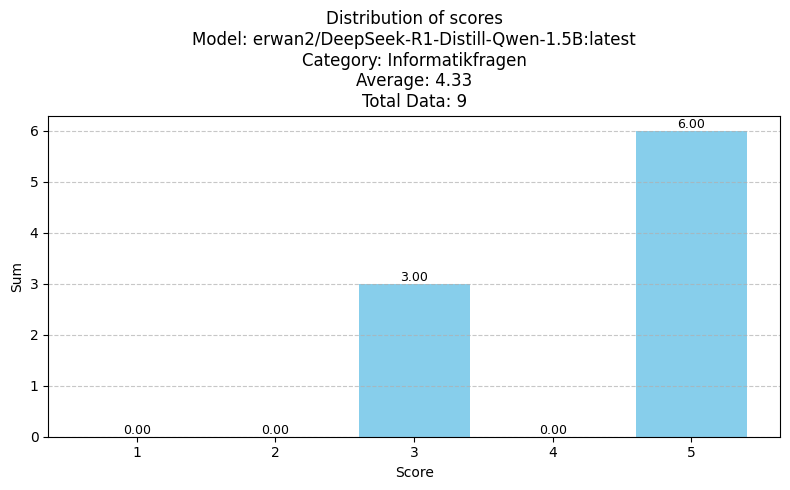

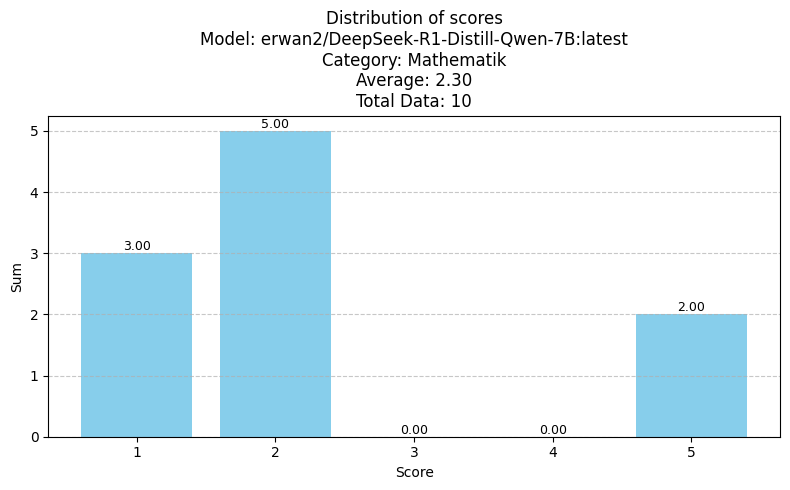

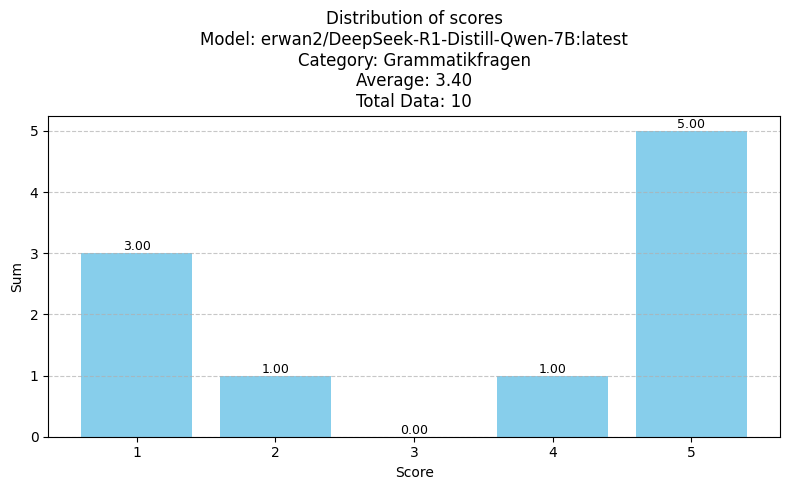

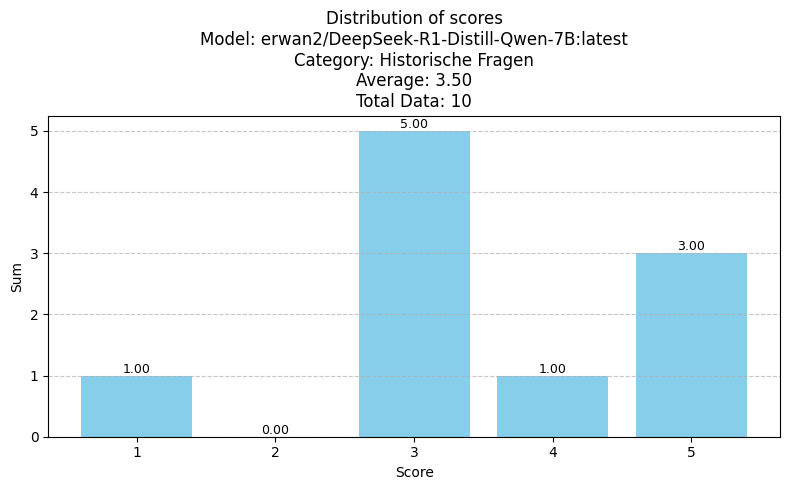

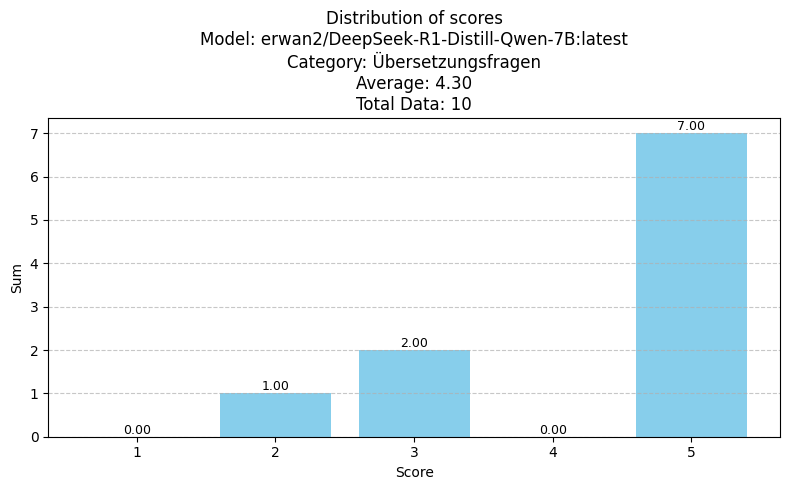

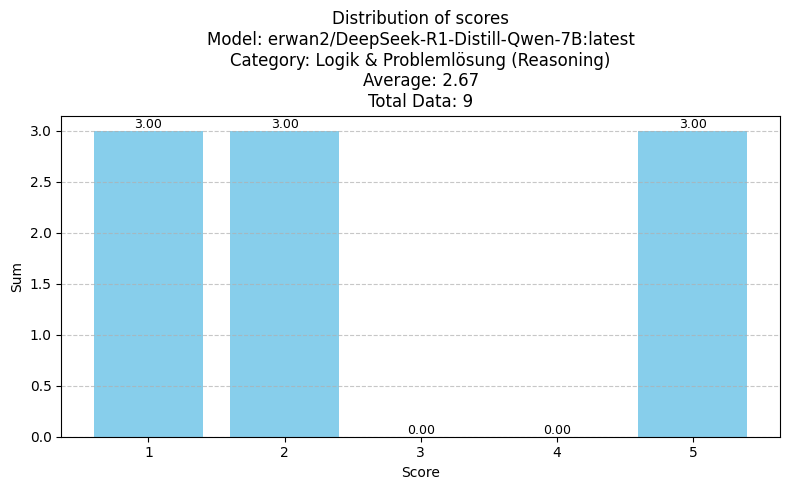

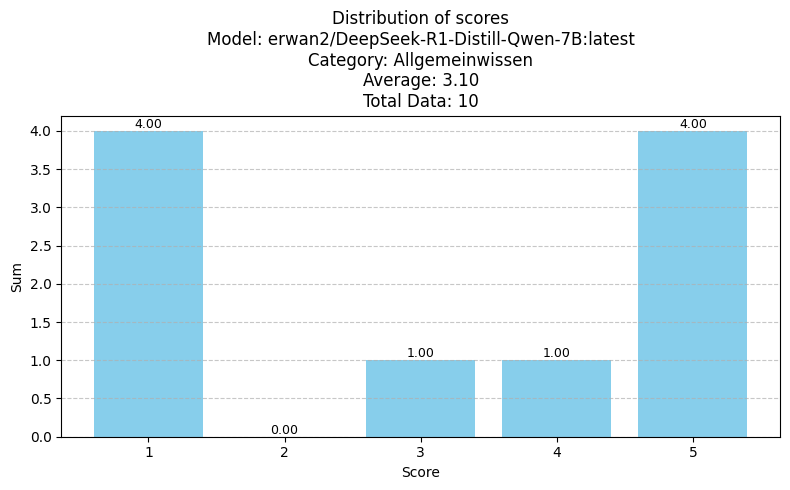

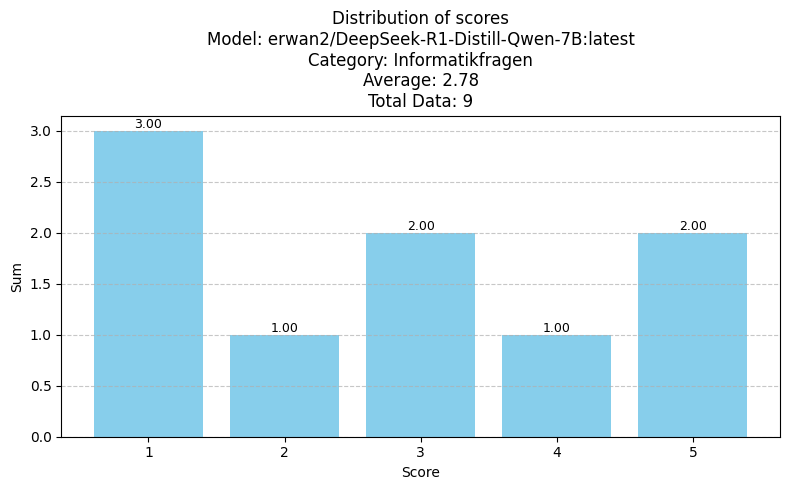

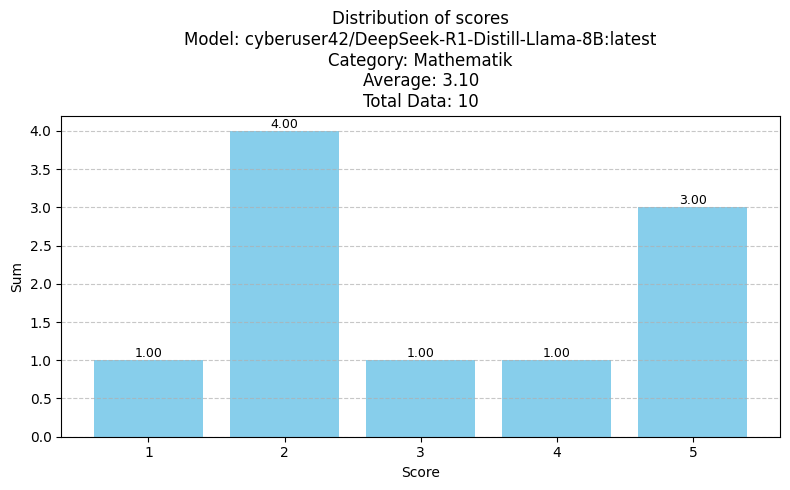

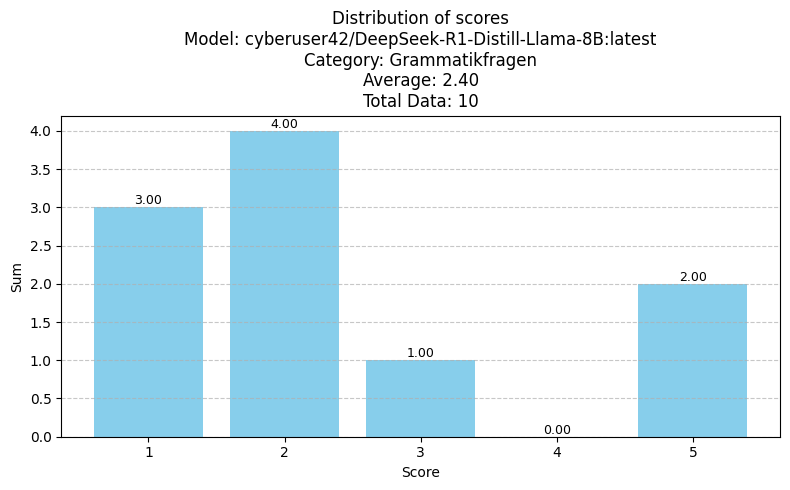

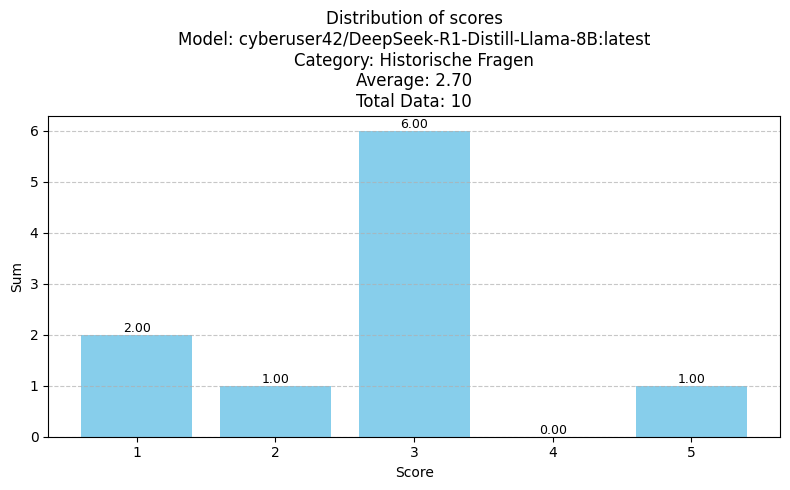

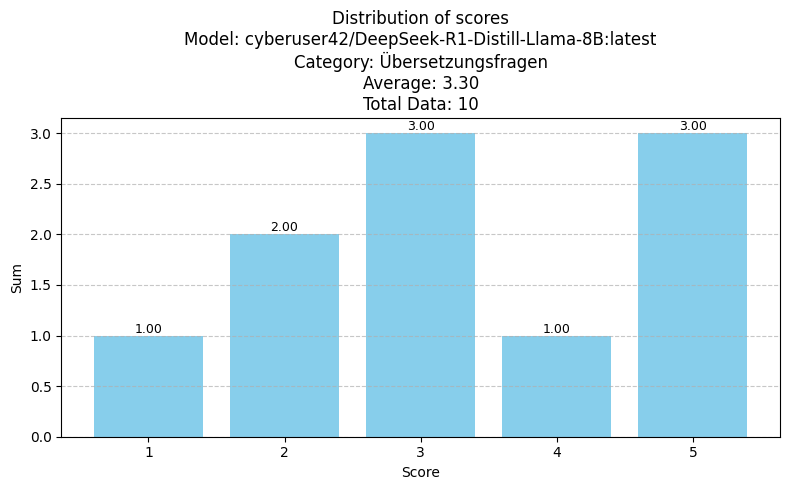

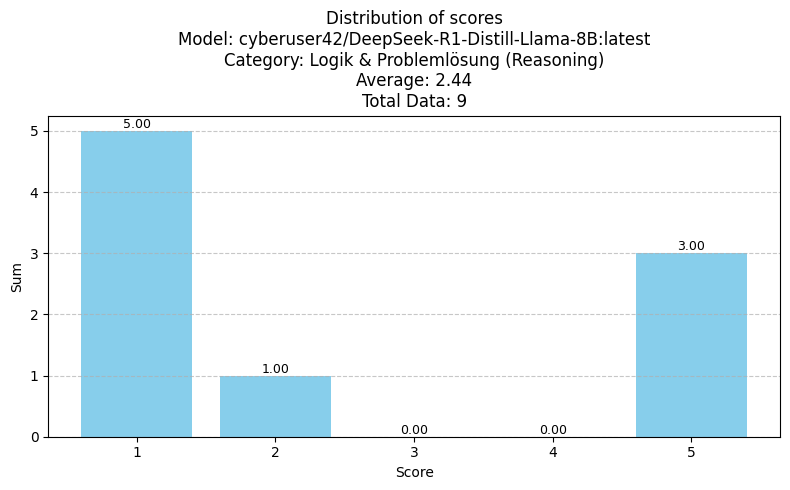

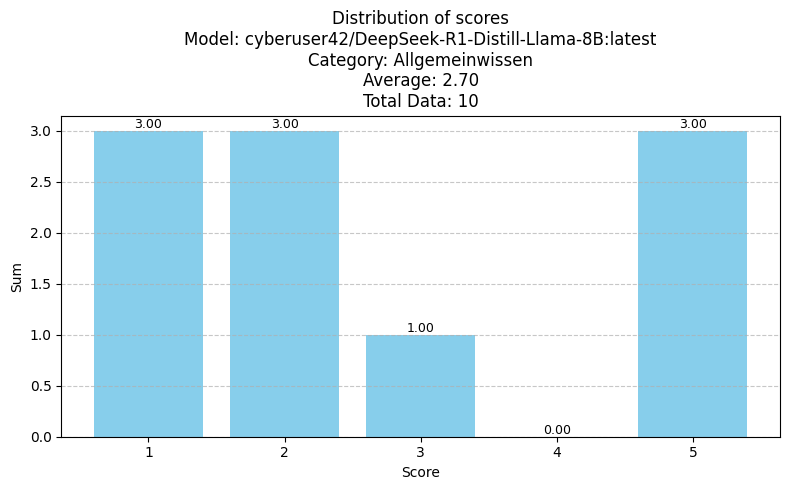

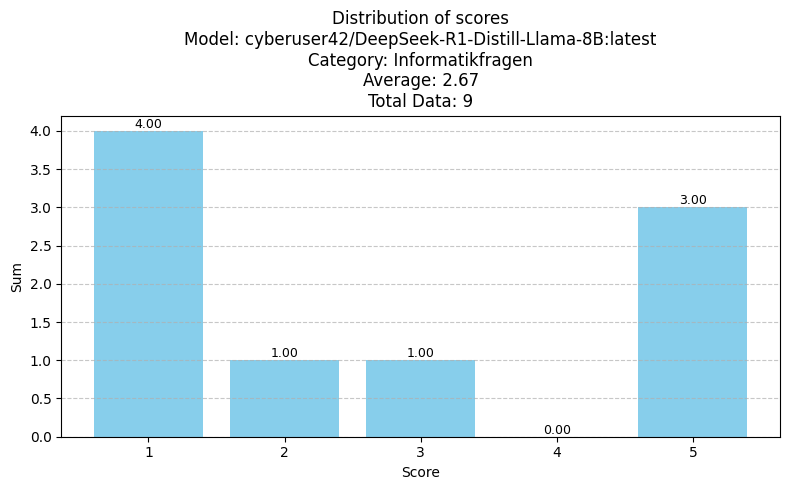

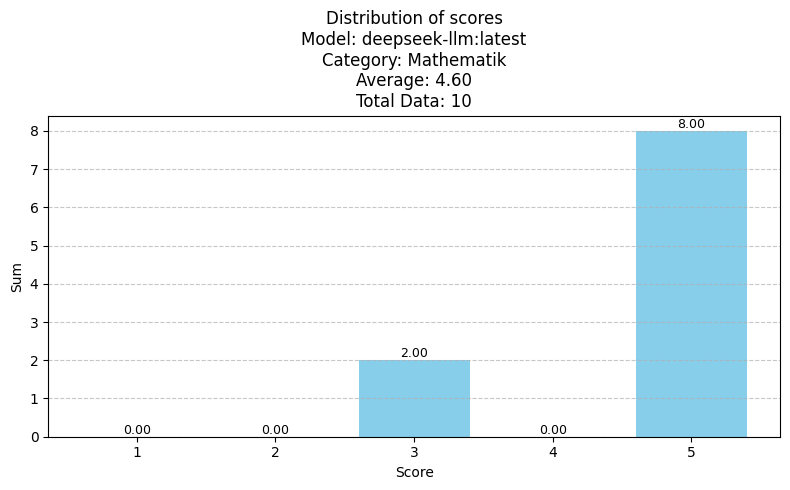

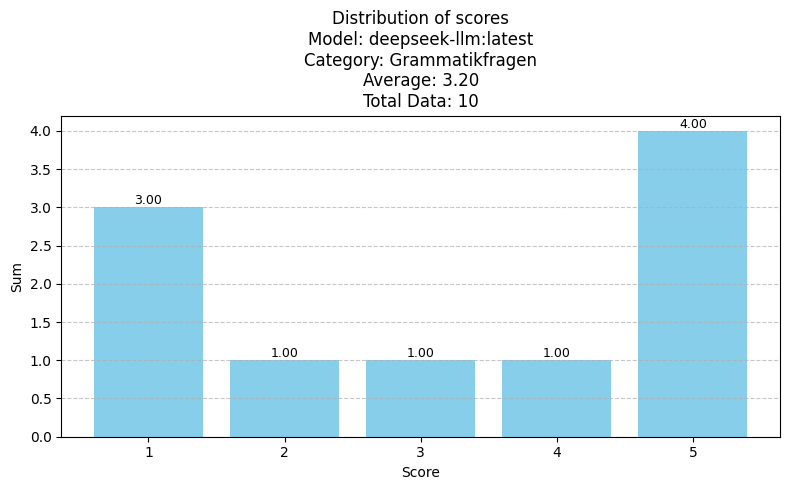

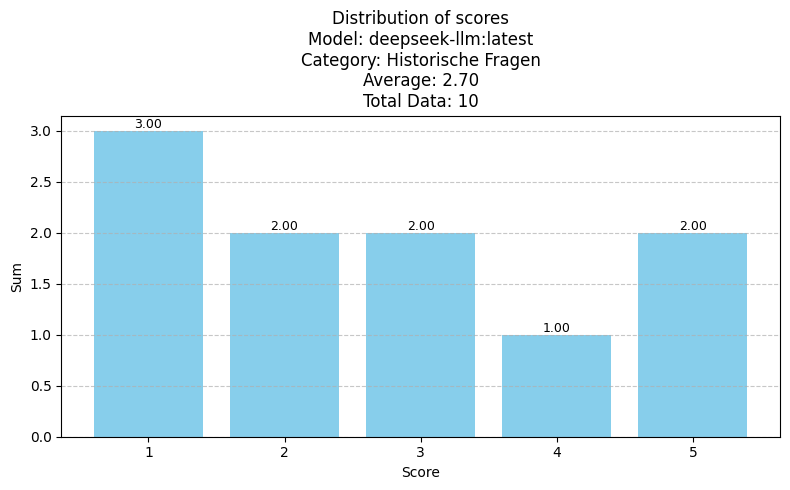

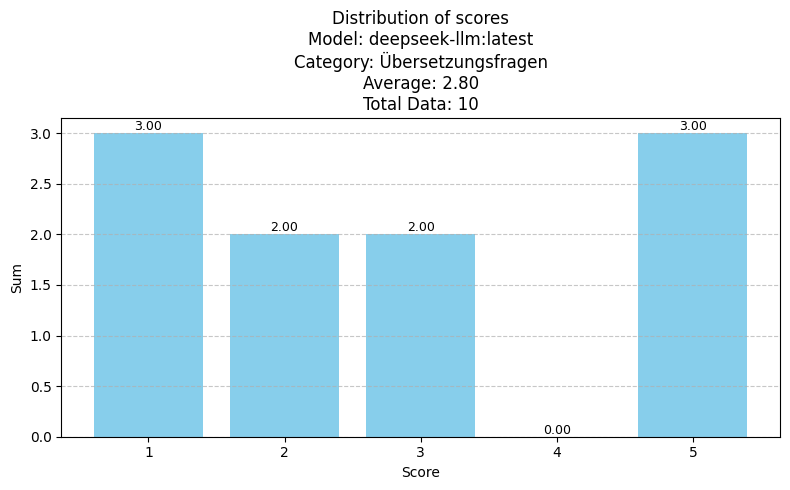

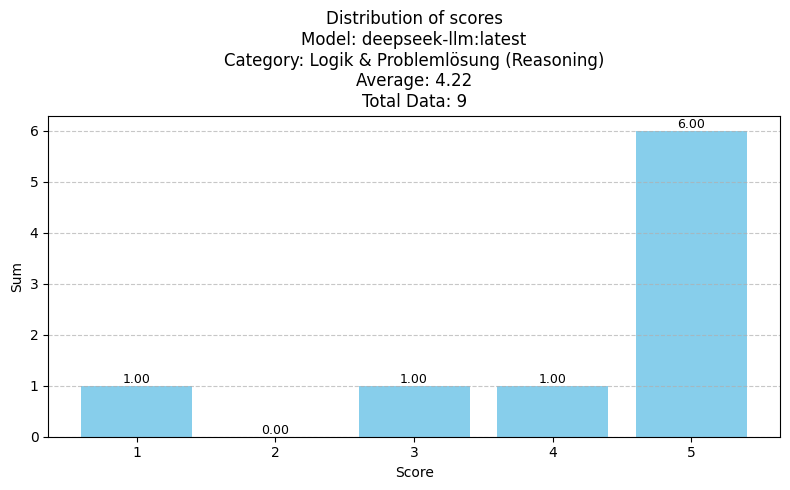

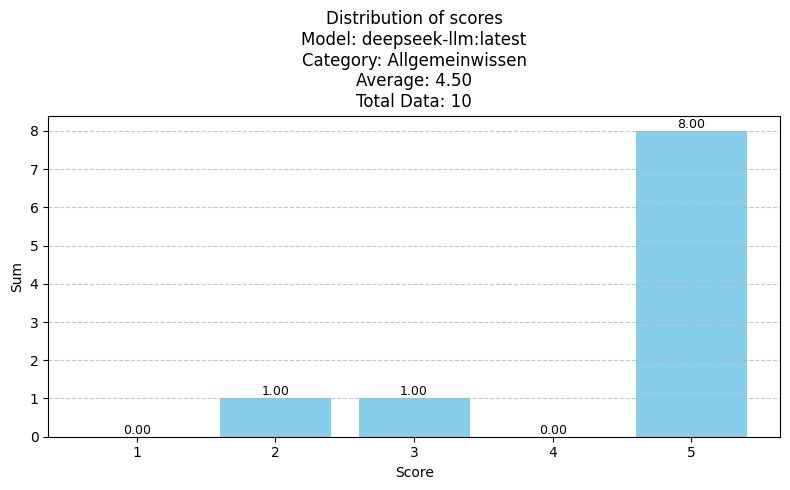

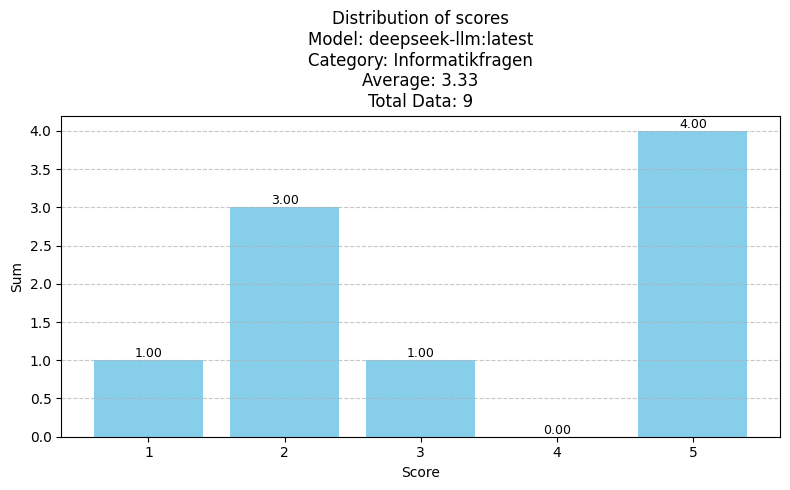

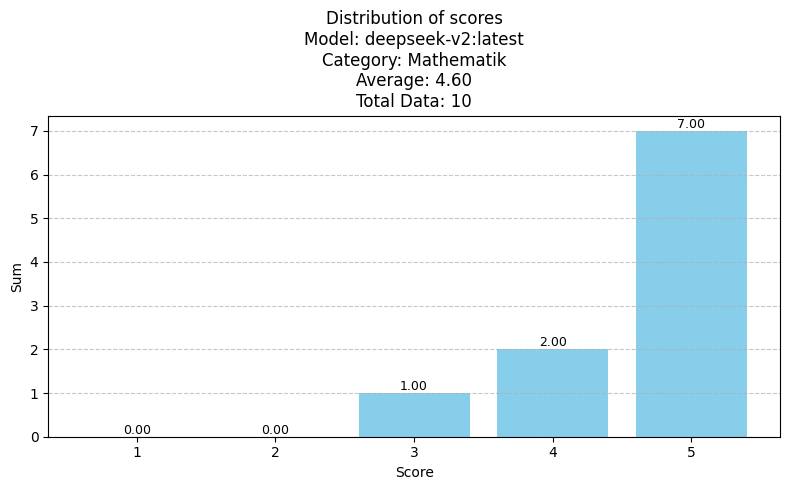

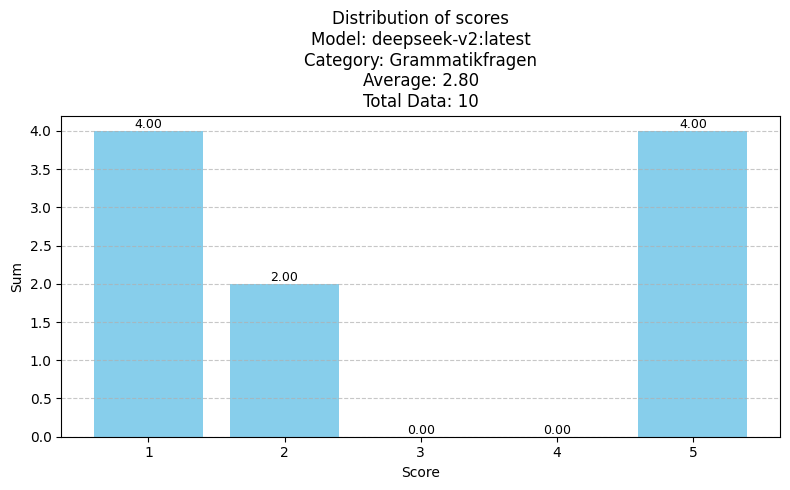

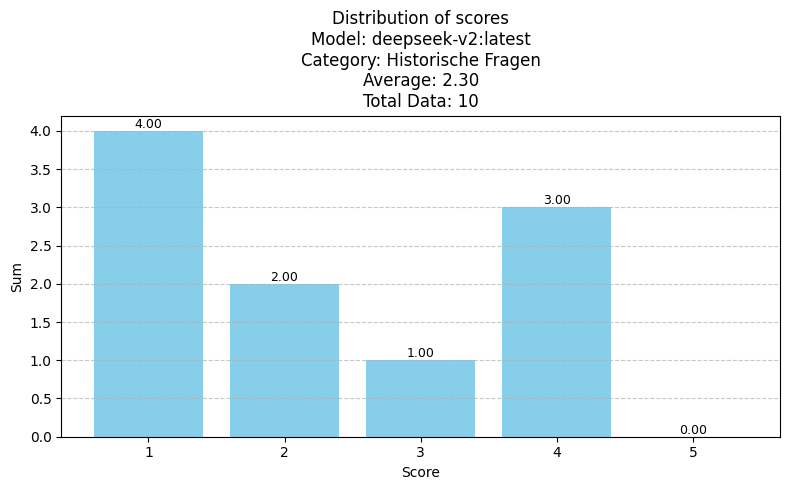

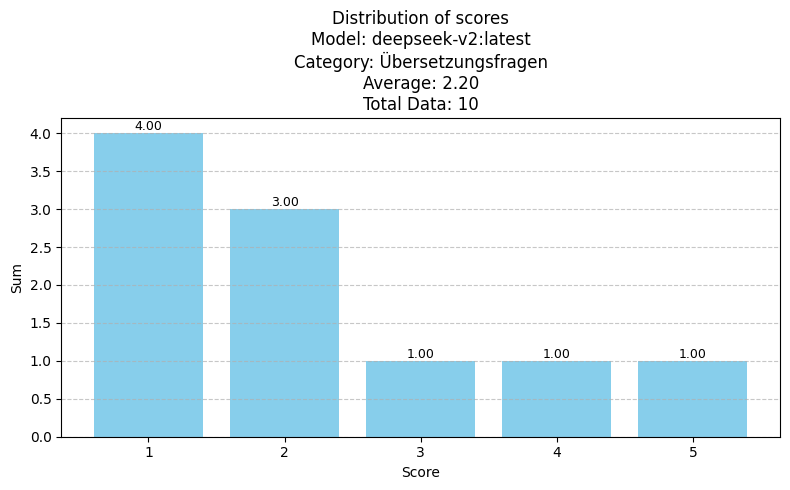

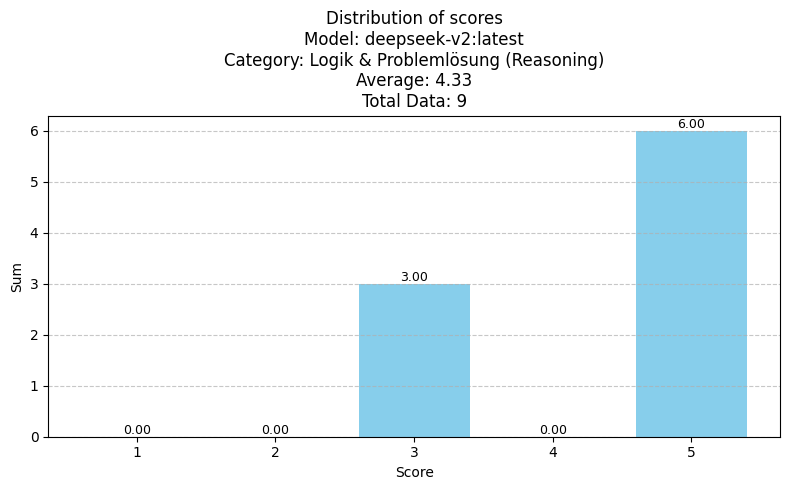

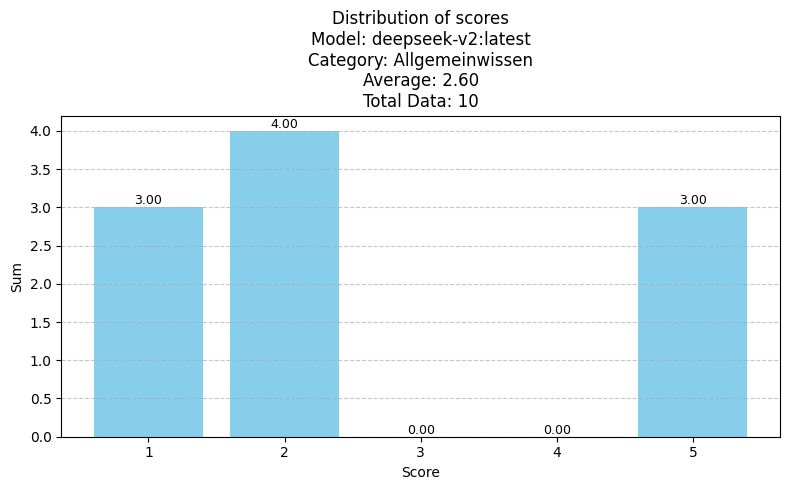

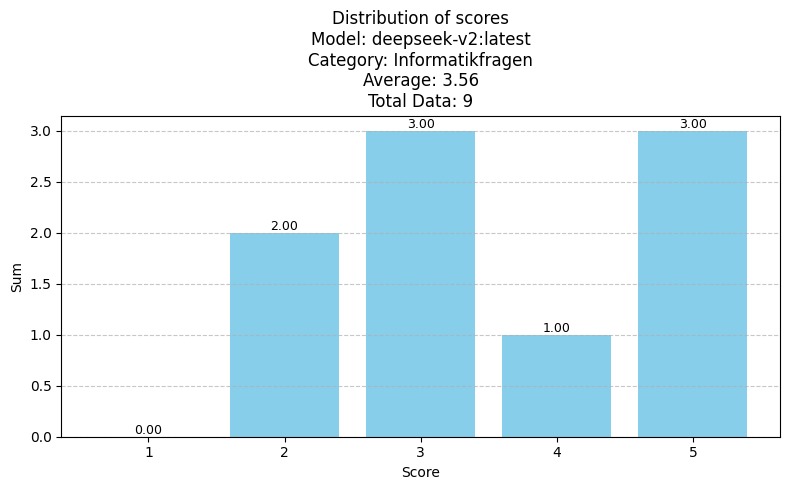

In [66]:
all_scores = []

for res_model in res_models:
    id_model = res_model['c_id']
    model = res_model['c_model']
    for res_category in res_categories:
        id_category = res_category['c_id']
        category = res_category['c_category']
        labels, data_scores = get_scores([{'t_model.c_id': id_model}, {'t_category.c_id': id_category}])
        data_average = get_score_average([{'t_model.c_id': id_model}, {'t_category.c_id': id_category}])
        show_plot_score(labels, data_scores, data_average, f'\nModel: {model}\nCategory: {category}', f'model_category/{format_filename(model)}', format_filename(category))
        all_scores.append({
            'model_id': id_model,
            'model': model,
            'category_id': id_category,
            'category': category,
            'average': data_average
        })

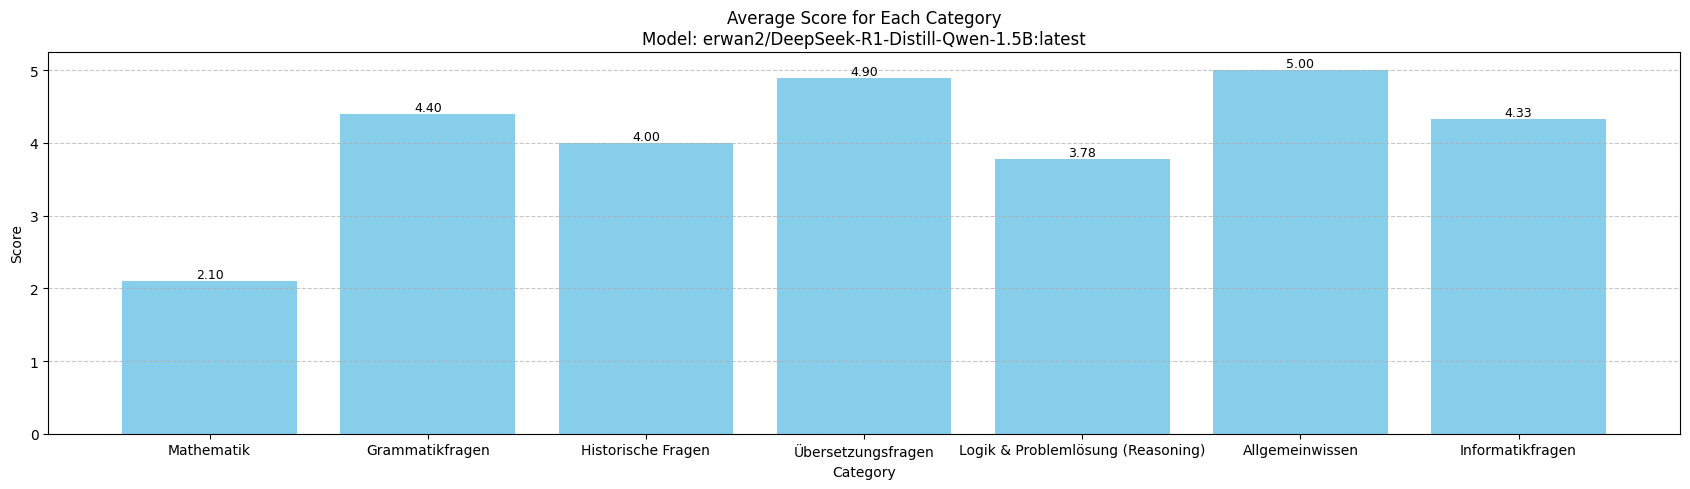

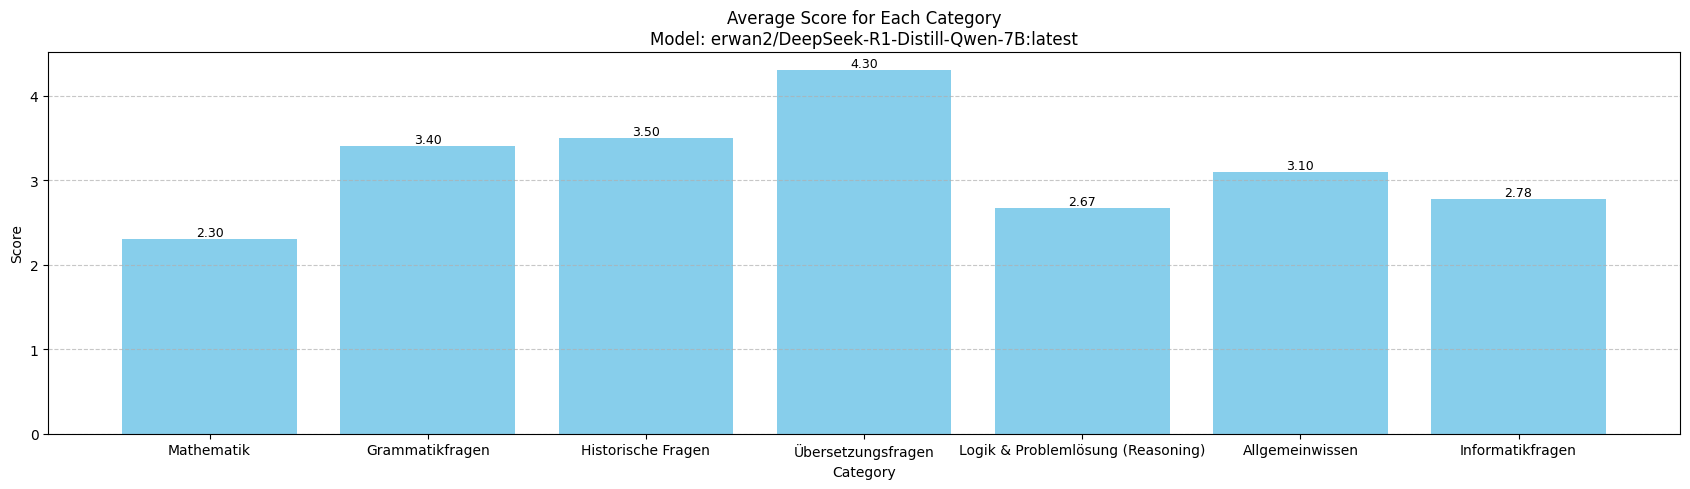

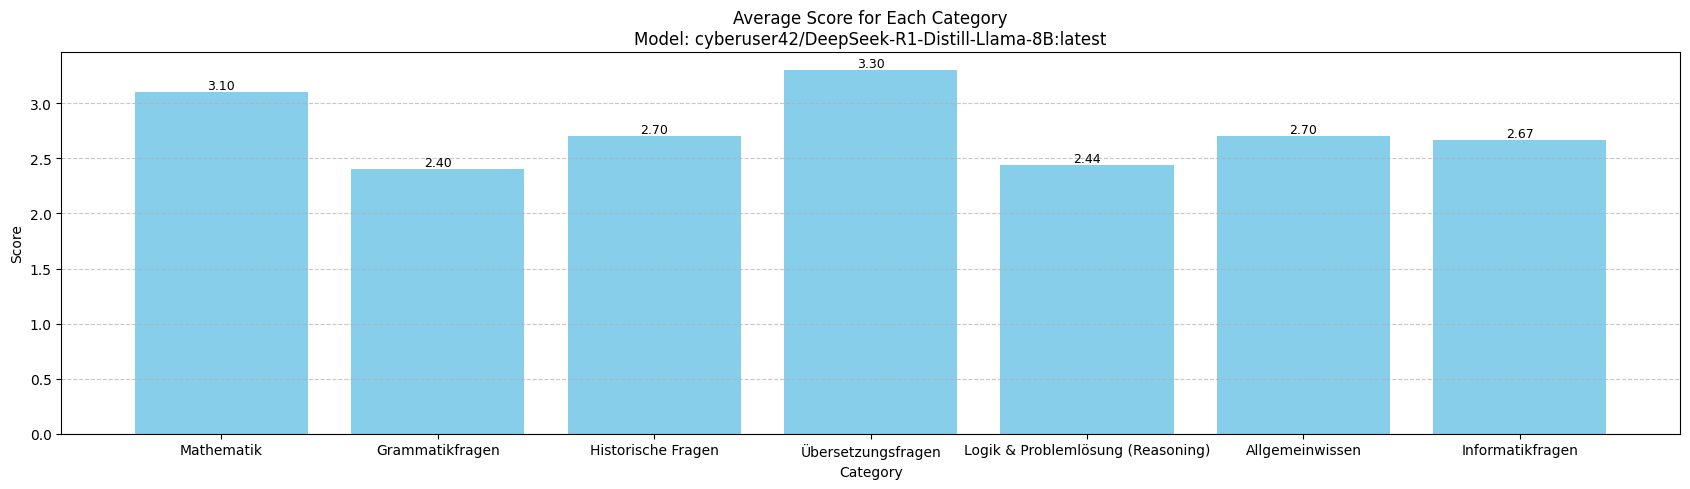

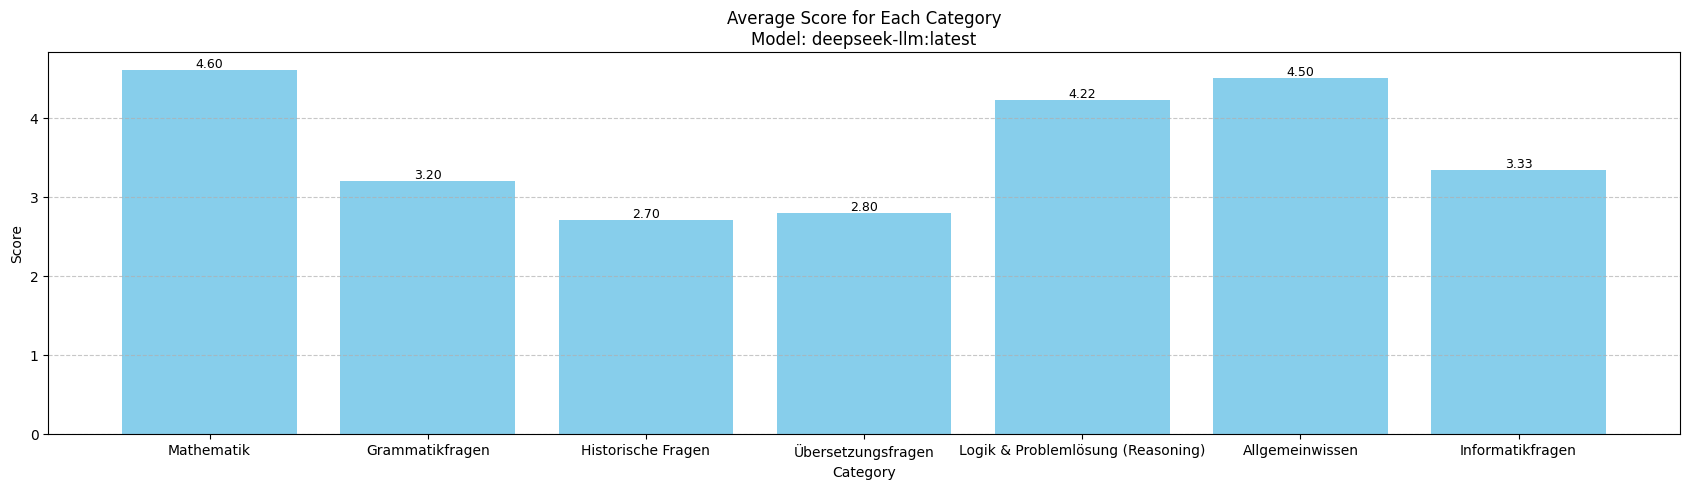

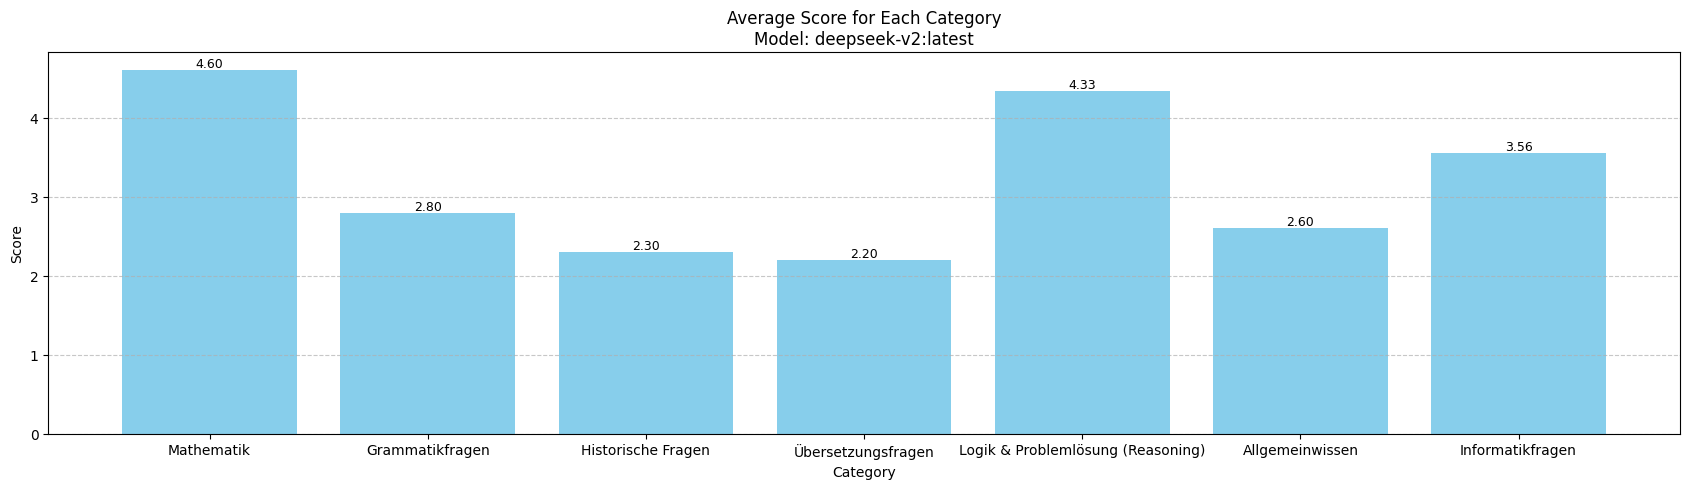

In [67]:
for res_model in res_models:
    model = res_model['c_model']
    result_average = [
        {'label': item['category'], 'data': item['average']}
        for item in all_scores if item['model'] == model
    ]
    show_plot_average(17, 5, result_average, f'Average Score for Each Category\nModel: {model}', 'Category', 'model_category', format_filename(model))

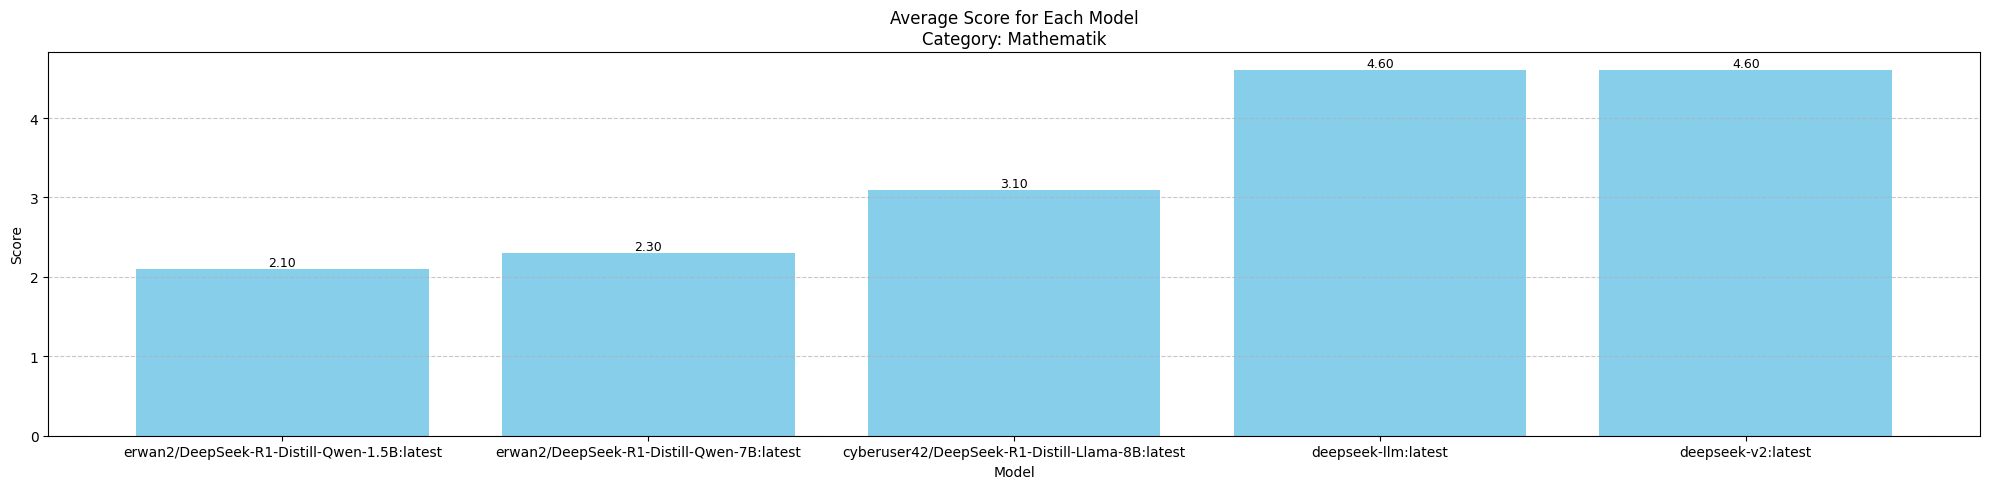

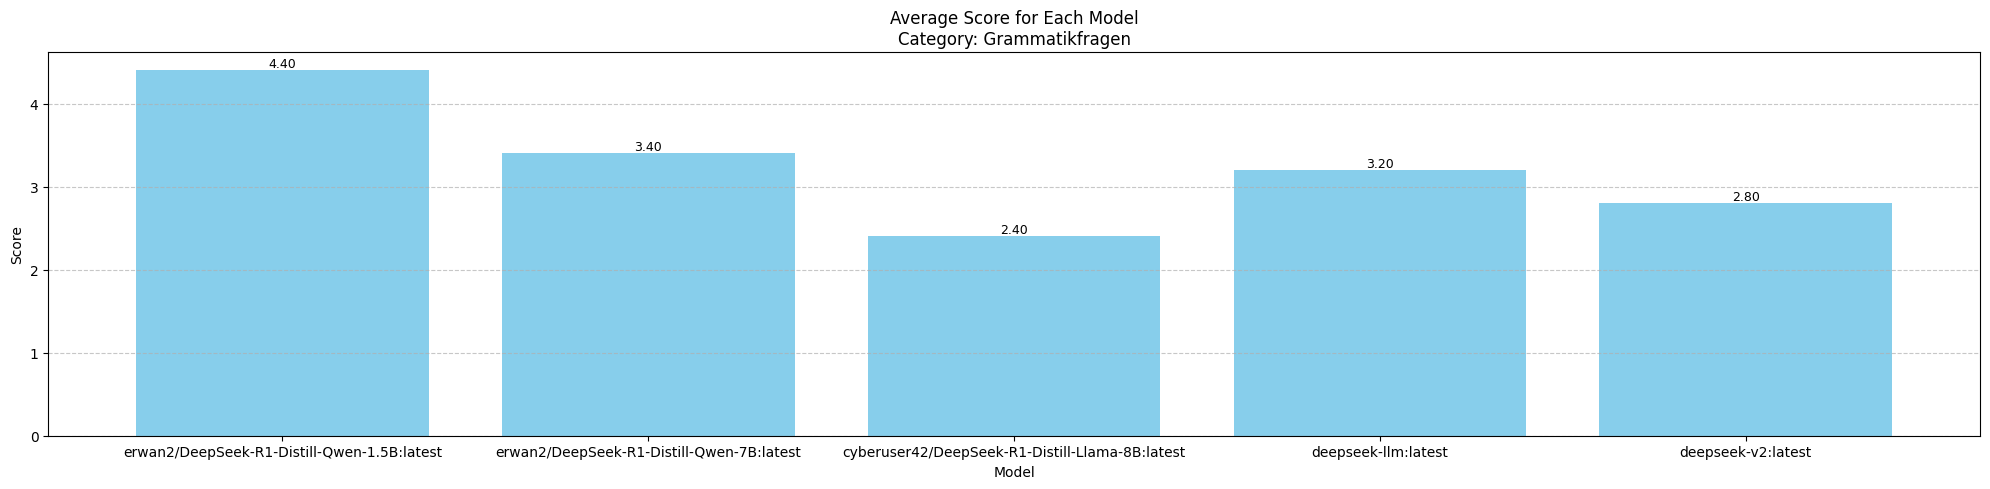

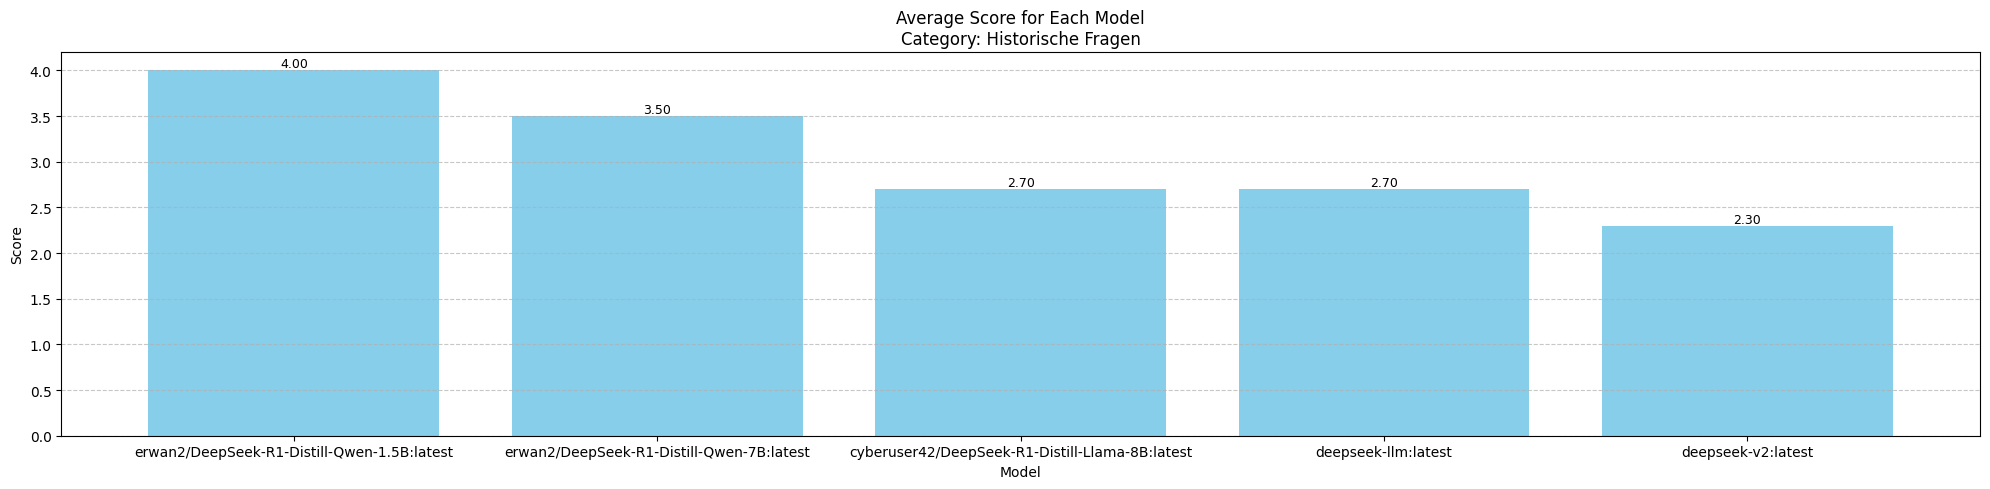

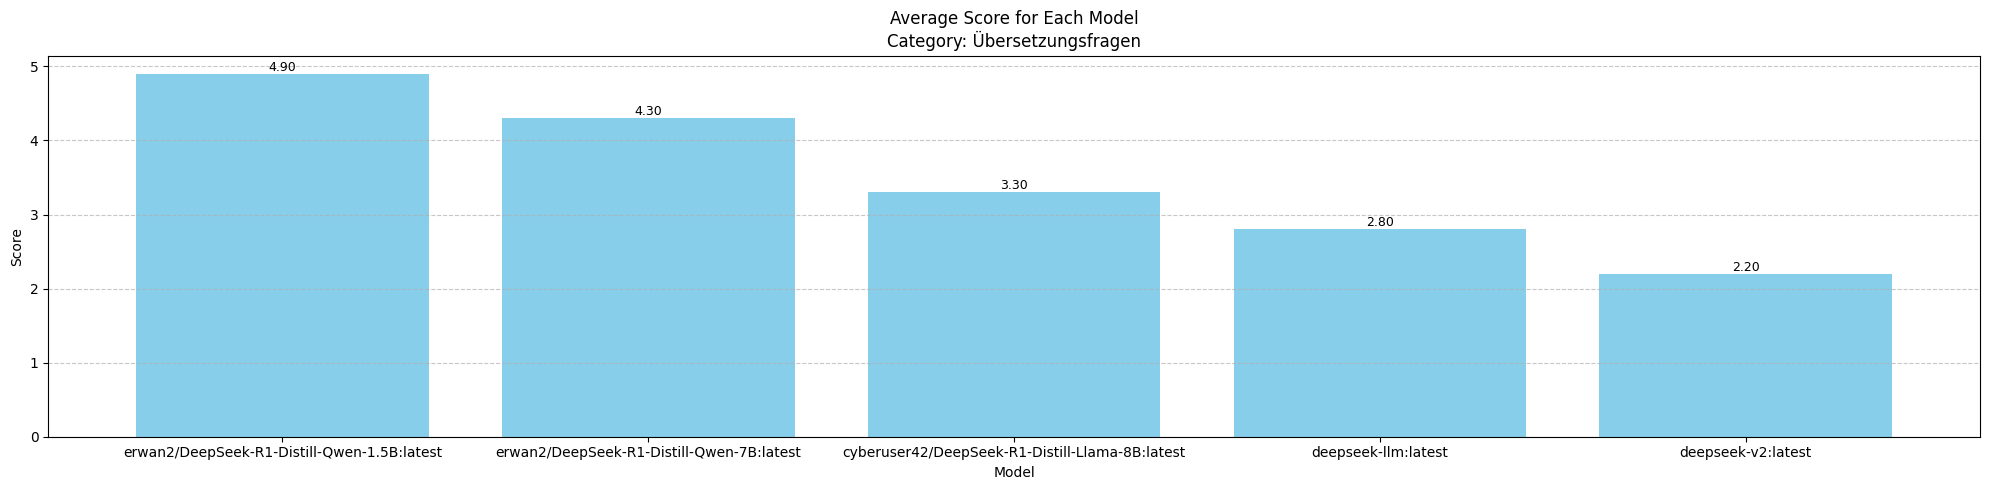

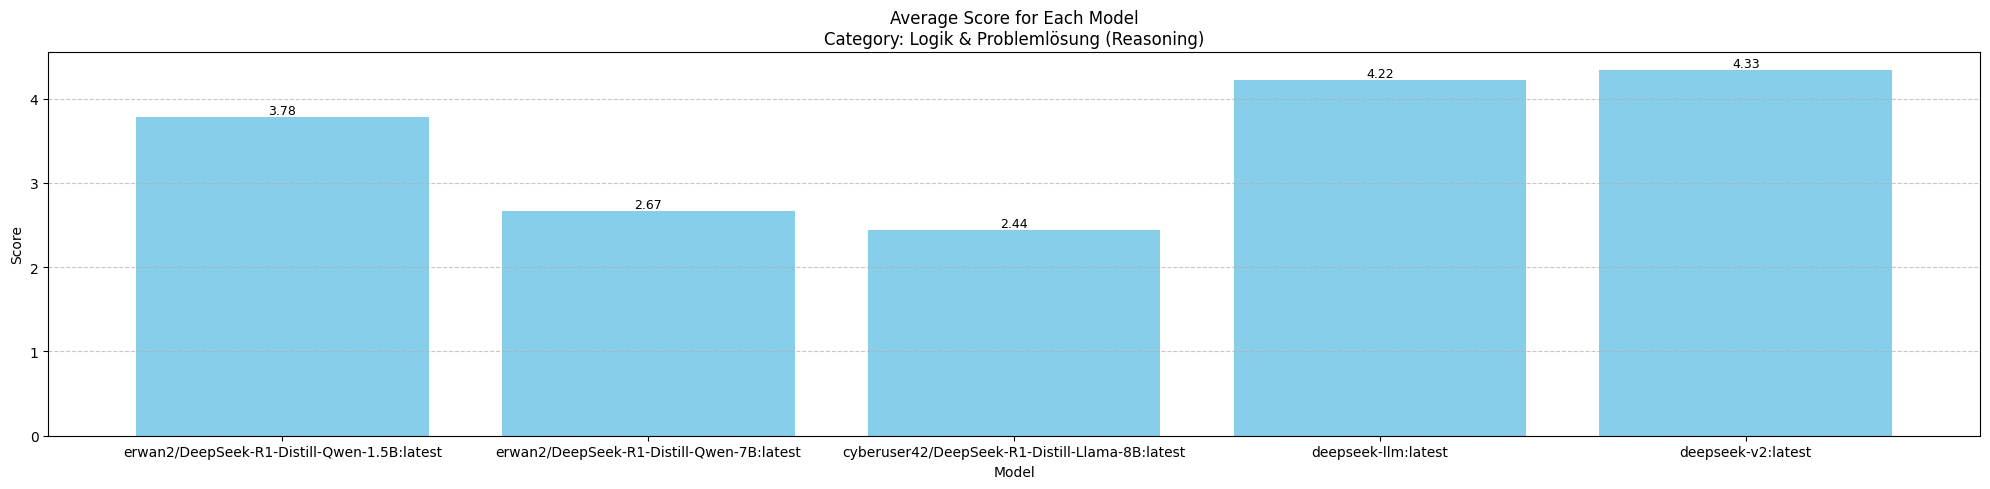

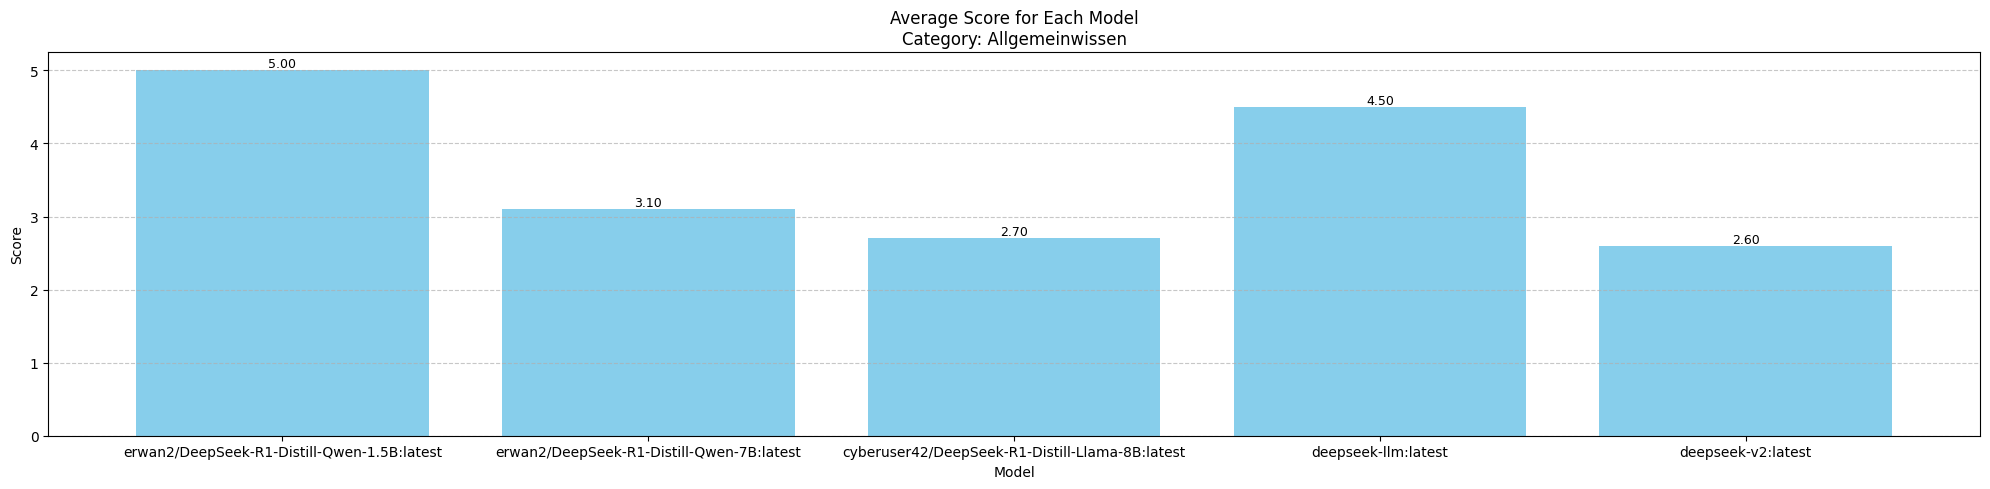

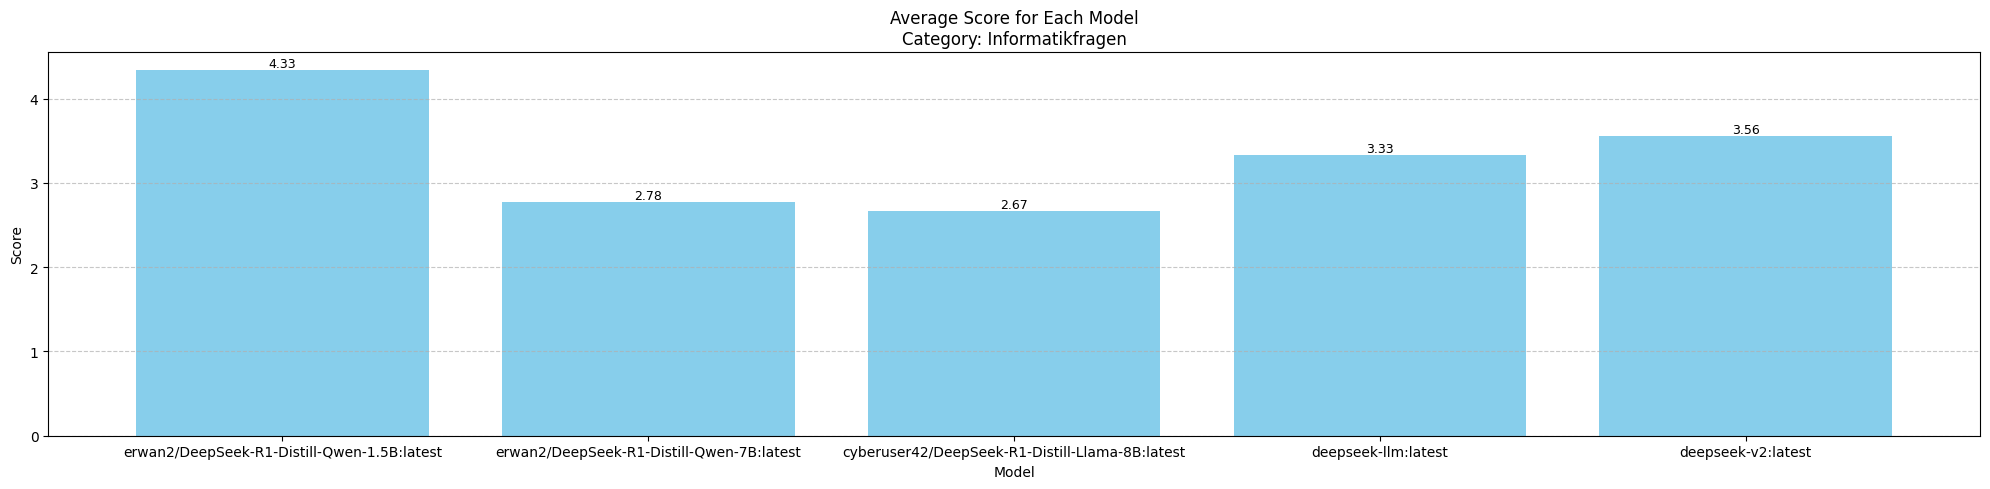

In [68]:
for res_category in res_categories:
    category = res_category['c_category']
    result_average = [
        {'label': item['model'], 'data': item['average']}
        for item in all_scores if item['category'] == category
    ]
    show_plot_average(20, 5, result_average, f'Average Score for Each Model\nCategory: {category}', 'Model', 'category_model', format_filename(category))